# Exercise 6: Simple Features


## Helper Functions

In [109]:
import numpy as np
import cv2 
import os
import scipy
import matplotlib.pyplot as plt
import matplotlib

def load_im(path : str) -> np.ndarray:
    """
        Returns:
            Image scaled to float.
    """
    im = cv2.imread(path)[:, :, ::-1]
    im = im.astype(np.float64) / 255
    
    return im


def pi(points : np.ndarray) -> np.ndarray:
    """
        Converts from homogeneous to inhomogeneous coordinates
    """
    p = points[:-1]/points[-1]
    
    return p


def piInv(points : np.ndarray) -> np.ndarray:
    """
        Converts from inhomogeneous to homogeneous coordinates
    """
    
    # Gets the amount of points by using shape
    _, num_points = points.shape
    
    # Stacks the scale s at the bottom of the matrix
    ph = np.vstack((points, np.ones(num_points)))
    
    return ph


def projectPoints(K, Rt, Q):
    
    Q_hom = piInv(Q)
    points = K @ Rt @ Q_hom
    points_inhom = pi(points)
    
    return points_inhom


def hest(q1, q2) -> np.ndarray:
    """
        Takes two points in 2D and returns the estimated homography matrix.
    """
    
    if len(q1) != len(q2):
        raise ValueError("There must be an equal amount of points in the two sets!")
    
    Bi = []
    for i in range(q1.shape[1]):
        qi = q1[:,i]   # <-- getting the first column
        
        # Creating that weird qx matrix for the Kronecker product
        q1x = np.array(
            [[0,        -1, qi[1]],
             [1,        0, -qi[0]],
             [-qi[1], qi[0], 0]]
        )
        
        q2t_hom = q2[:, i].reshape(-1, 1) # <-- getting the first column and reshaping does for dim: (1, ) -> (1,1)
        Bi.append(np.kron(q2t_hom.T, q1x)) # <-- formula follows that of week 2, slide 56
        # print(np.kron(q2t_hom.T, q1x).shape)
       
    B = np.concatenate(Bi, axis=0)
    
    # Some TA prooved that it was unneseccary to find their dot product
    #BtB = B.T @ B
    V, Lambda, Vt = np.linalg.svd(B)
    Ht = Vt[-1, :]
    
    Ht = np.reshape(Ht, (3, 3))
    H = Ht.T
    
    return H
    
    
def crossOp(p : np.ndarray) -> np.ndarray:
    """
        One of Them weird functions. It takes in a 3D vector and then returns
        some gnarly matrix.
    """
    p = p.flatten()
    if p.size != 3:
        raise Exception("Invalid input, vector must be exactly 3D.")
    
    x, y, z = p
    px = np.array(
        [[0, -z, y],
         [z, 0, -x],
         [-y, x, 0]]
    )
    
    return px


def computeFundamentalMatrix(K1 : np.ndarray, K2 : np.ndarray, R2 : np.ndarray, t2 : np.ndarray) -> np.ndarray:
    """
        Computing the fundamental matrix between two camera matrices K1 & K2.
    """
    t2x = crossOp(t2)

    E = t2x @ R2

    K1inv = np.linalg.inv(K1)
    K2inv = np.linalg.inv(K2)

    F = K1inv.T @ E @ K2inv
    
    return F


def fancyRotate(theta_x, theta_y, theta_z):
    """
        Does the rotation matrix that we have seen a few times.
        E.g. Exercises week 4, eq(12).
    """
    from scipy.spatial.transform import Rotation
    
    R = Rotation.from_euler("xyz", [theta_x, theta_y, theta_z]).as_matrix()
    
    return R




## Ex. 6.1

Create the function: `g, gd = gaussian1DKernel(sigma)`, where `g` is the **1D Gaussian Kernel**, `gd` is the derivative of **g**, and `sigma` is the **Gausian width**.

Test for different multiples of sigma.

Should normalize `g`, such that it sums to 1.

### Response

In [110]:
def gaussian1DKernel(sigma: float, SDs: int = 3) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
        Takes in:
            The standard deviation: sigma
            
            (optional - 3 as default) The amount of standard deviations: SDs
            (From statistics we know that 3 standard deviations encapsulates 99.7% of the Gaussian distribution)
        
        Returns:
            The 1D Gaussian kernel: g
            
            The derivative: gd
    """
    
    # Morten was very big brains when he definde this kernel!
    bounds = round(SDs * sigma)
    x = np.arange(-bounds, bounds + 1)
    
    g_unorm = np.exp(- x**2/(2 * sigma**2))
    g = g_unorm / g_unorm.sum() # <-- makes sure that g sums to one (SUCH THAT IS A PROPABILITY DISTRIBUTION!)
    
    gd = -x / (sigma**2) * g
    
    return g, gd
    

In [111]:
def gaussianFunction(sigma : float) -> tuple[np.ndarray, np.ndarray]:
    """
        Takes in:
            The standard deviation: sigma
        
        Returns:
            The 1D Gaussian function (over 500 steps): g
            
            The derivative: gd
            
            The interval: x
    """
    
    STEP_SIZE = 500
    
    # From statistics we know that this encapsulates 99.7% of the Gaussian distribution
    SDs = 3
    x = np.linspace(-SDs * sigma, SDs * sigma, STEP_SIZE)
    
    
    g_unorm = np.exp(- x**2/(2 * sigma**2))
    g = g_unorm / g_unorm.sum() # <-- makes sure that g sums to one (SUCH THAT IS A PROPABILITY DISTRIBUTION!)
    
    gd = -x / (sigma**2) * g
    
    return g, gd, x

#### Testing the implemented `gaussianFunction`

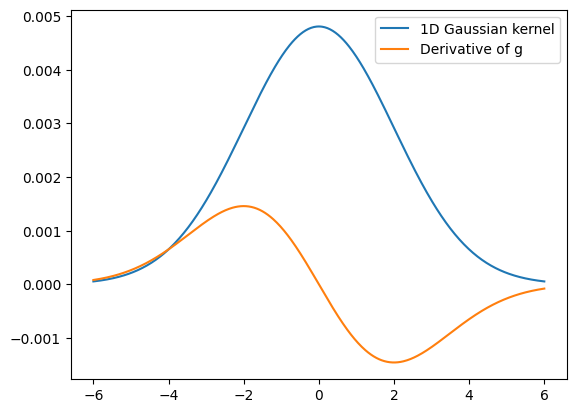

In [112]:
sigma = 2
g, gd, x = gaussianFunction(sigma)

plt.figure()
plt.plot(x, g, label = "1D Gaussian kernel")
plt.plot(x, gd, label = "Derivative of g")
plt.legend()
plt.show()


#### Test of `gaussian1DKernel`

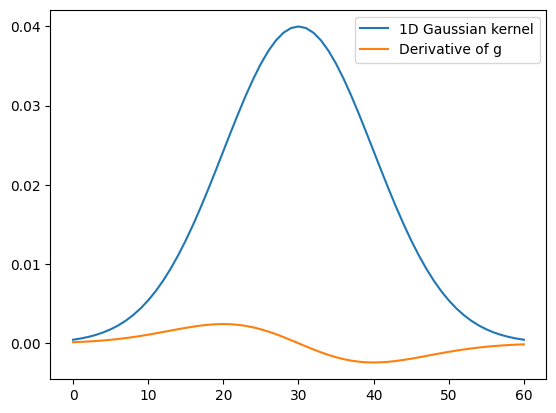

In [122]:
sigma = 10
g, gd = gaussian1DKernel(sigma)

plt.figure()
plt.plot(g, label = "1D Gaussian kernel")
plt.plot(gd, label = "Derivative of g")
plt.legend()
plt.show()


## Ex. 6.2
Create the function `I, Ix, Iy = gaussianSmoothing(im, sigma)`.


### Response

(300, 300)


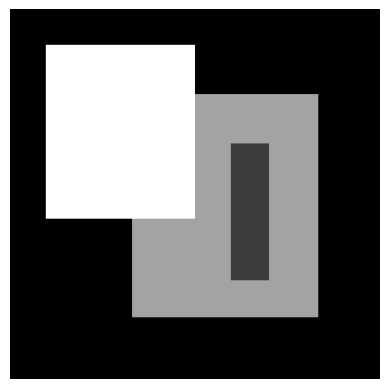

In [123]:
# Loading image
im01 = load_im("data/Lauge_spiser.jpg")
im02 = load_im("data/TestIm1.png")

# Converting to greyscale
rgb_weights = [0.2989, 0.5870, 0.1140]

rgb2grey = lambda im : np.dot(im[...,:3], rgb_weights)  # <-- rgb2grey lambda function, wow!

im01_grey = rgb2grey(im01)
im02_grey = rgb2grey(im02)
print(im02_grey.shape)

plt.figure()
plt.imshow(im02_grey, cmap="gray")
plt.axis("off")
plt.show()


In [124]:
def gaussianSmoothing(im : np.ndarray, sigma : float) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
        Takes:
            The image as a numpy array: im
            
            The standard deviation: sigma
        
        Returns:
            The smoothed image: I
            
            The smoothed x-derivative of the image: Ix
            
            The smoothed y-derivative of the image: Iy
    """
    
    g, gd = gaussian1DKernel(sigma)
    
    im_smooth = cv2.sepFilter2D(im, -1, g, g)
    
    Ix = cv2.sepFilter2D(im, -1, gd, g)
    
    Iy = cv2.sepFilter2D(im, -1, g, gd)
    
    return im_smooth, Ix, Iy
    

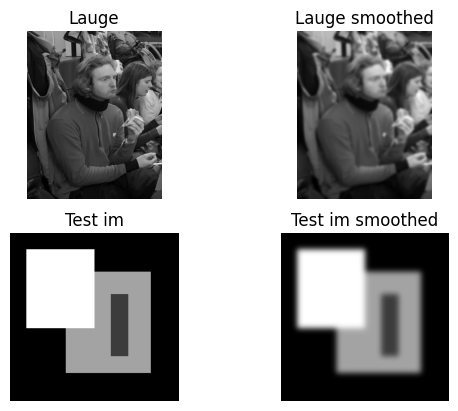

In [132]:
im01_smoothed, im01x, im01y = gaussianSmoothing(im01_grey, 10)
im02_smoothed, im02x, im02y = gaussianSmoothing(im02_grey, 5)
#print(im01_smoothed.min(), im01_smoothed.max())

fig, ax = plt.subplots(2,2)

ax[0, 0].imshow(im01_grey, cmap='gray')
ax[0, 0].set_title('Lauge')
ax[0, 0].axis("off")

ax[0, 1].imshow(im01_smoothed, cmap='gray')
ax[0, 1].set_title('Lauge smoothed')
ax[0, 1].axis("off")

ax[1, 0].imshow(im02_grey, cmap='gray')
ax[1, 0].set_title('Test im')
ax[1, 0].axis("off")

ax[1, 1].imshow(im02_smoothed, cmap='gray')
ax[1, 1].set_title('Test im smoothed')
ax[1, 1].axis("off")

plt.show()

^^^

I think it is correct...

## Ex. 6.3 
We will now create the function `C = smoothedHessian(im, sigma, epsilon)`, where:

$$
    \pmb{C}(x, y) =
    \begin{bmatrix}
        g_{\epsilon} * Ix^2(x,y) & g_{\epsilon} * Ix(x, y) * I(x,y)
        \\
        g_{\epsilon} * Ix(x, y) * I(x,y) & g_{\epsilon} * Iy^2(x,y)
    \end{bmatrix},
$$
where $g_{\epsilon} * ...$ is the convolution of a new Gaussian kernel with width `epsilon`.

### Response

In [117]:
def smoothedHessian(im : np.ndarray, sigma : float, epsilon : int) -> np.ndarray:
    """
        Takes:
            The image as a numpy array: im
            
            The standard deviation: sigma
            
            The width of the Gaussian kernel: epsilon
        
        Returns:
            The smoothed hessian: C
    """
    
    g_eps, _ = gaussian1DKernel(epsilon, SDs = 1)
    
    _, Ix, Iy = gaussianSmoothing(im, sigma)
    
    a = cv2.sepFilter2D(Ix**2, -1, g_eps, g_eps)
    b = cv2.sepFilter2D(Iy**2, -1, g_eps, g_eps)
    c = cv2.sepFilter2D(Ix * Iy, -1, g_eps, g_eps)
    
    C = np.array(
        [[a, c],
         [c, b]]
    )
    
    return C

## Ex. 6.4 
Create the function `r = harrisMeasure(im, sigma, epsilon, k)` where,
$$
    \begin{align*}
        \pmb{r}(x, y) &= a \cdot b - c^2 - k \cdot (a + b)^2,
        \\
        \pmb{C}(x, y) &= 
        \begin{bmatrix}
            a & c
            \\
            c & b
        \end{bmatrix}
    \end{align*}
$$

### Response

In [118]:
def harrisMeasure(im : np.ndarray, sigma : float, epsilon : int, k : float = 0.06) -> np.ndarray:
    """
        Takes:
            The image as a numpy array: im
            
            The standard deviation: sigma
            
            The width of the Gaussian kernel: epsilon
            
            (Optional - default is 0.06) Some real scaling factor: k
        
        Returns:
            The harris measure: r
    """
    
    C = smoothedHessian(im, sigma, epsilon)
    
    a = C[0, 0]
    b = C[1, 1]
    c = C[0, 1]
    
    #if c != C[1, 0]:
    #    raise ValueError("Something went wrong in the previous function, oh no!")
    
    r = a * b - c**2 - k * (a + b)**2
    
    return r
    

#### Testing

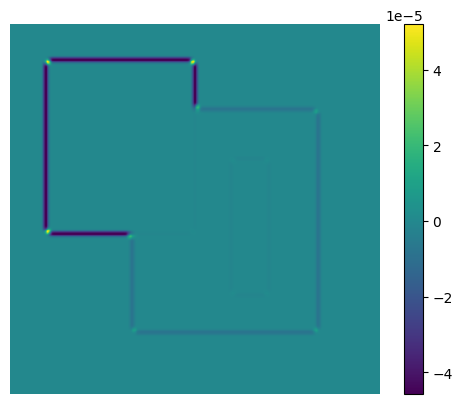

In [119]:
r02 = harrisMeasure(im02_grey, 2, 2)

plt.figure()
plt.imshow(r02)
plt.colorbar()
plt.axis("off")
plt.show()


Lauge med prikker giver ikke rigtigt mening... :(

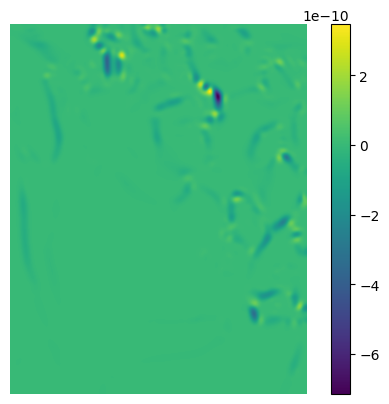

In [136]:
r01 = harrisMeasure(im01_grey, 20, 20)

plt.figure()
plt.imshow(r01)
plt.colorbar()
plt.axis("off")
plt.show()

## Ex. 6.5
Create function `c = cornerDetector(im, sigma, epsilon, k, tau)` where `c` is a list of points, where `r` is the local maximum and larger than som releative threshold i.e.

$$
    \pmb{r}(x, y) > \texttt{tau}.
$$

### Response

In [145]:
def cornerDetector(im : np.ndarray, sigma : float, epsilon : int, k : float = 0.06, tau : float = None) -> list:
    """
        Takes:
            The image as a numpy array: im
            
            The standard deviation: sigma
            
            The width of the Gaussian kernel: epsilon
            
            (optional - default a tenth of max value of harris meassure) Threshold: tau
            
            (Optional - default is 0.06) Some real scaling factor: k
            
        Returns:
            List of detected corners: c
    """
    
    
    r = harrisMeasure(im, sigma, epsilon)
    if tau is None:
        tau = 0.1 * np.max(r, axis = None)  # <-- defined as per week 6, slide 31
    
    mask = r > tau     # <-- boolean array
    
    # non-maximum suprresion
    mask[:-1, :] *= r[:-1, :] > r[1:, :] 
    mask[1:, :] *= r[1:, :] > r[:-1, :]
    mask[:, :-1] *= r[:, :-1] > r[:, 1:]
    mask[:, 1:] *= r[:, 1:] > r[:, :-1]
    
    mask[1:, 1:] *= r[1:, 1:] > r[:-1, :-1] 
    mask[:-1, :-1] *= r[:-1, :-1] > r[1:, 1:]
    
    c = np.where(mask)
    c = np.array([c[1], c[0]])  # < -- apparently np.where switches the two coordinates
    
    return c
    

#### Testing - Lauge

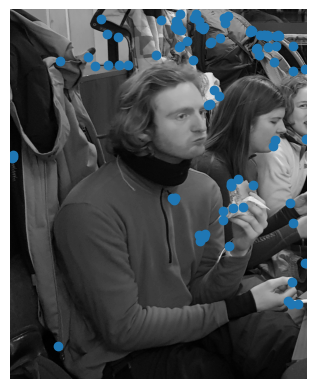

In [146]:
c = cornerDetector(im01_grey, 2, 2)

plt.figure()
plt.imshow(im01_grey, cmap="gray")
plt.scatter(c[0], c[1])
plt.axis("off")
plt.show()

#### Testing - test image

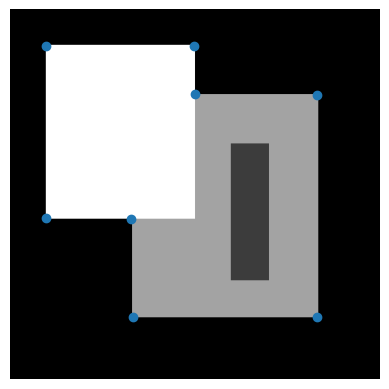

In [148]:
c = cornerDetector(im02_grey, 0.5, 1)

plt.figure()
plt.imshow(im02_grey, cmap="gray")
plt.scatter(c[0], c[1])
plt.axis("off")
plt.show()